In [1]:
%matplotlib inline
import pandas as pd 
from enum import Enum
import cv2
import matplotlib.pyplot as plt
import numpy as np


datafile = "./Data/driving_log.csv"

df = pd.read_csv(datafile)
df.head()

,center,left,right,steering,throttle,brake,speed
0,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,-0.089202,0.4,0,30.03756
1,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,-0.089202,0.4,0,30.03826
2,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,-0.089202,0.4,0,30.03813
3,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,-0.089202,0.4,0,30.03816
4,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,/home/tak/CarND-Term1-Starter-Kit/Projects/Pro...,-0.089202,0.4,0,30.03813


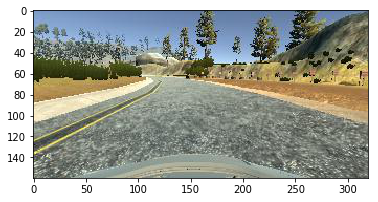

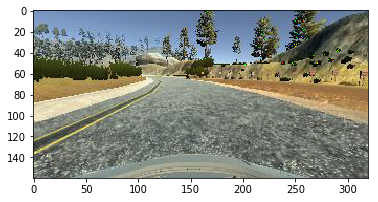

In [2]:
samplefile = df['center'][0]
img = cv2.imread(samplefile)
imageshape = img.shape
v = np.random.randint(-40,40)
rbgo = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv[:,:,2] = hsv[:,:,2] +v
rbg = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

plt.imshow(rbgo)
plt.show()


plt.imshow(rbg)
plt.show()



In [3]:
def HShiftandBrightess(img, istrainning=True):
    if (istrainning):
        offsetfactor = 10 #parameter
        brightnessvalue = 25

        n = np.random.randint(-offsetfactor,offsetfactor) 
        resultimg = np.zeros_like(img)
        width = resultimg.shape[1]
        if (n>0):
            resultimg[:,:(width-n)] = img[:,n:]
        else:
            resultimg[:,-n:] = img[:,:(width+n)] 

        # Convert BGR to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        hsv[:,:,2] =  hsv[:,:,2] + int(np.random.randint(-brightnessvalue,brightnessvalue))
        resultimg = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    else:
        resultimg = img
    return resultimg


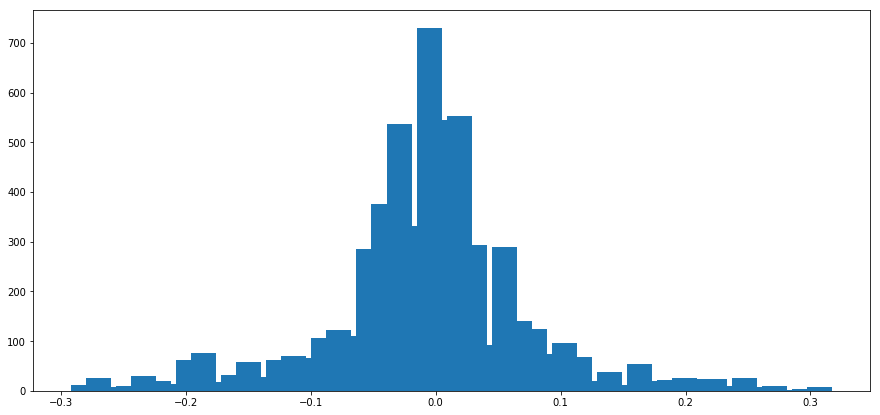

[-0.2816902, -0.26967142, -0.25765263999999999, -0.24563385999999998, -0.23361507999999997, -0.22159629999999997, -0.20957751999999996, -0.19755873999999995, -0.18553995999999995, -0.17352117999999994, -0.16150239999999993, -0.14948361999999993, -0.13746483999999992, -0.12544605999999991, -0.11342727999999991, -0.1014084999999999, -0.089389719999999895, -0.077370939999999888, -0.065352159999999881, -0.053333379999999882, -0.041314599999999882, -0.029295819999999882, -0.017277039999999882, -0.0052582599999998828, 0.006760520000000117, 0.018779300000000117, 0.030798080000000116, 0.042816860000000116, 0.054835640000000116, 0.066854420000000109, 0.078873200000000115, 0.090891980000000122, 0.10291076000000013, 0.11492954000000014, 0.12694832000000014, 0.13896710000000015, 0.15098588000000016, 0.16300466000000016, 0.17502344000000017, 0.18704222000000018, 0.19906100000000018, 0.21107978000000019, 0.2230985600000002, 0.2351173400000002, 0.24713612000000021, 0.25915490000000019, 0.271173680000

In [4]:
maxangle =max(df['steering'])
minangle = min(df['steering'])

step = (maxangle-minangle)/50

binangle = {}

i = minangle

while (i<maxangle):
    binangle[i] = 0
    for item in df['steering']:
        if (item >=i and item < i+step):
            binangle[i] +=1
    i += step
    
fig, ax = plt.subplots(figsize = (15,7))

ax.bar(list(binangle.keys()), list(binangle.values()), .02)

plt.show()
print (sorted(list(binangle.keys())))


In [5]:
len(df)

5762

In [6]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

KTF.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [7]:
from sklearn.model_selection import train_test_split
import sklearn 
batch_size = 64



def generator(df, batch_size=32, istrainning = True):
    num_samples = len(df)
    filenameprefix = ''
                
    while 1:
        correction = 0.27
        for offset in range(0, num_samples,batch_size):
            batchdatas = df.iloc[offset:offset+batch_size]
            X_data= []
            y_data = []
            for img_center, img_left, img_right,steering_center in zip (batchdatas['center'],batchdatas['left'],batchdatas['right'], batchdatas['steering']):
                steering_center = float(steering_center)
                img_center = filenameprefix+img_center
                X_data.append(HShiftandBrightess(cv2.imread(img_center),istrainning))
                y_data.append(steering_center)
                X_data.append(np.fliplr(HShiftandBrightess(cv2.imread(img_center),istrainning)))
                y_data.append(-steering_center)   
                img_left = (filenameprefix+img_left).replace(" ","")
                img_right = filenameprefix+img_right.replace(" ","")

                steering_left = steering_center + correction
                steering_right = steering_center - correction
                X_data.append(HShiftandBrightess(cv2.imread(img_left),istrainning))
                y_data.append(steering_left)  
                X_data.append(HShiftandBrightess(cv2.imread(img_right),istrainning))
                y_data.append(steering_right) 
            X_data = np.array(X_data)
            y_data = np.array(y_data)
            yield sklearn.utils.shuffle(X_data, y_data)

train_samples, validation_samples = train_test_split(df, test_size=0.2)

In [8]:
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size, False)

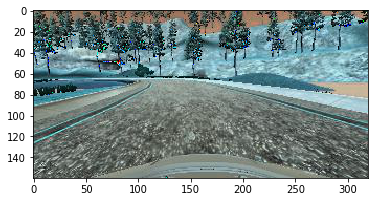

In [9]:
img = next(train_generator)[0][0]
plt.imshow(img)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Reshape
from keras.layers import MaxPooling2D, Flatten, BatchNormalization
from keras.layers.convolutional import Convolution2D
from keras import optimizers
import keras
from keras.models import load_model
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras.callbacks import ModelCheckpoint


epochs = 10

model = Sequential()
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(imageshape)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
#model.add(MaxPooling2D())
model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
#model.add(MaxPooling2D())
model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
#model.add(MaxPooling2D())
model.add(Convolution2D(64, 3, 3))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling2D())
model.add(Convolution2D(64, 3, 3))
#model.add(BatchNormalization())
model.add(Activation('elu'))
#model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1164))
model.add(Dropout(.50))
model.add(Dense(100))
model.add(Dropout(.50))
model.add(Dense(50))
model.add(Dropout(.50))
model.add(Dense(10))
model.add(Dense(1))

         

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 65, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 158, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 31, 158, 24)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [12]:
model.compile(loss='mse',
              optimizer='adam', learningrate = 0.0005)


filepath = 'NvidiaModel.{epoch:02d}.h5'
saveModel = ModelCheckpoint(filepath, monitor='val_loss',
                            verbose=0, save_best_only=False, 
                            save_weights_only=False,
                            mode='auto', period=1)

saveBestModel = ModelCheckpoint('NvidiaBestModel.h5', monitor='val_loss',
                            verbose=0, save_best_only=True, 
                            save_weights_only=False,
                            mode='auto', period=1)


model.fit_generator(generator = train_generator,
          samples_per_epoch= len(train_samples)*4,
          validation_data = validation_generator,
          nb_val_samples= len(validation_samples)*4,
          nb_epoch=epochs, callbacks = [saveModel, saveBestModel])
         

/home/tak/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1917: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/10
18436/18436 [==============================] - 39s - loss: 0.0486 - val_loss: 0.0365
Epoch 2/10
18436/18436 [==============================] - 34s - loss: 0.0376 - val_loss: 0.0352
Epoch 3/10
18436/18436 [==============================] - 35s - loss: 0.0339 - val_loss: 0.0309
Epoch 4/10
18436/18436 [==============================] - 37s - loss: 0.0307 - val_loss: 0.0292
Epoch 5/10
18436/18436 [==============================] - 36s - loss: 0.0286 - val_loss: 0.0299
Epoch 6/10
18436/18436 [==============================] - 35s - loss: 0.0277 - val_loss: 0.0275
Epoch 7/10
18436/18436 [==============================] - 35s - loss: 0.0250 - val_loss: 0.0247
Epoch 8/10
18436/18436 [==============================] - 35s - loss: 0.0233 - val_loss: 0.0343
Epoch 9/10
18436/18436 [==============================] - 33s - loss: 0.0276 - val_loss: 0.0268
Epoch 10/10
18436/18436 [==============================] - 34s - loss: 0.0235 - val_loss: 0.0235
